<a href="https://colab.research.google.com/github/wajihh/learning-data-science/blob/master/vae_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Auto Encoder
Below is an example of a Python project demonstrating the use of Variational Autoencoders (VAEs) with KL divergence and transfer learning. We will use the MNIST dataset for simplicity, but the concepts can be extended to other datasets and applications.

## Project Overview
Load and Preprocess Data: Load the MNIST dataset and preprocess it.
Build and Train a VAE: Construct a Variational Autoencoder, train it on the MNIST dataset, and demonstrate the use of KL divergence in the loss function.
Transfer Learning: Fine-tune the pre-trained VAE on a smaller subset of the MNIST dataset.

# Step 1: Load and pre process data


In [2]:
pip install numpy matplotlib tensorflow


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K

# Load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

print("Training data shape:", x_train.shape)
print("Testing data shape:", x_test.shape)


11490434/11490434 [==============================] - 0s 0us/step
Training data shape: (60000, 28, 28, 1)
Testing data shape: (10000, 28, 28, 1)


# Step 2: Build and Train Data

In [4]:
# VAE model parameters
input_shape = (28, 28, 1)
batch_size = 128
latent_dim = 2
epochs = 50

# Encoder
inputs = Input(shape=input_shape, name='encoder_input')
x = Flatten()(inputs)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Use reparameterization trick to push the sampling out as input
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Decoder
decoder_input = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(256, activation='relu')(decoder_input)
x = Dense(512, activation='relu')(x)
x = Dense(np.prod(input_shape), activation='sigmoid')(x)
outputs = Reshape(input_shape)(x)

# Instantiate encoder and decoder models
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(decoder_input, outputs, name='decoder')

# Instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

# Define VAE loss
reconstruction_loss = binary_crossentropy(K.flatten(inputs), K.flatten(outputs)) * np.prod(input_shape)
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

# Train VAE
vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))


Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 encoder (Functional)        [(None, 2),                  534276    ['encoder_input[0][0]']       
                              (None, 2),                                                          
                              (None, 2)]                                                          
                                                                                                  
 decoder (Functional)        (None, 28, 28, 1)            534544    ['encoder[0][2]']             
                                                                                                

# Step 3: Transfer Learning

In [5]:
# Fine-tuning on a smaller subset of MNIST
(x_train_small, _), (x_test_small, _) = mnist.load_data()
x_train_small = x_train_small[:1000].astype('float32') / 255.
x_test_small = x_test_small[:100].astype('float32') / 255.
x_train_small = np.reshape(x_train_small, (len(x_train_small), 28, 28, 1))
x_test_small = np.reshape(x_test_small, (len(x_test_small), 28, 28, 1))

# Freeze the encoder layers except the last layer
for layer in encoder.layers[:-1]:
    layer.trainable = False

# Recompile the VAE with the new settings
vae.compile(optimizer='adam')

# Fine-tune the VAE
vae.fit(x_train_small, epochs=epochs, batch_size=batch_size, validation_data=(x_test_small, None))


Epoch 1/50
8/8 [==============================] - 1s 57ms/step - loss: 130.4320 - val_loss: 134.5598
Epoch 2/50
8/8 [==============================] - 0s 31ms/step - loss: 128.7712 - val_loss: 135.1102
Epoch 3/50
8/8 [==============================] - 0s 29ms/step - loss: 127.7387 - val_loss: 134.5947
Epoch 4/50
8/8 [==============================] - 0s 27ms/step - loss: 127.1738 - val_loss: 135.0526
Epoch 5/50
8/8 [==============================] - 0s 28ms/step - loss: 127.0248 - val_loss: 134.6309
Epoch 6/50
8/8 [==============================] - 0s 31ms/step - loss: 126.5335 - val_loss: 135.2468
Epoch 7/50
8/8 [==============================] - 0s 30ms/step - loss: 126.5086 - val_loss: 135.2575
Epoch 8/50
8/8 [==============================] - 0s 27ms/step - loss: 125.9718 - val_loss: 134.7601
Epoch 9/50
8/8 [==============================] - 0s 27ms/step - loss: 125.7828 - val_loss: 135.6358
Epoch 10/50
8/8 [==============================] - 0s 27ms/step - loss: 125.6848 - val_loss

Detailed Explanation
Data Loading and Preprocessing:

We load the MNIST dataset and normalize it to the range [0, 1].
The data is reshaped to include a channel dimension, which is required for Keras.
VAE Construction:

The encoder part of the VAE compresses the input image to a lower-dimensional latent space.
The decoder part reconstructs the image from the latent space.
The sampling function applies the reparameterization trick, which is crucial for backpropagation through the stochastic nodes.
The VAE loss is composed of the reconstruction loss and the KL divergence. The reconstruction loss measures how well the VAE can reconstruct the input, while the KL divergence regularizes the latent space to follow a standard normal distribution.
Transfer Learning:

We load a smaller subset of the MNIST dataset.
We freeze the layers of the encoder (except the last layer) to retain the learned features from the pre-trained model.
We recompile the VAE and fine-tune it on the smaller dataset, adjusting the latent space for the new data.

## Step 4: Compare Samples

79/79 [==============================] - 1s 9ms/step
Epoch 1/50
8/8 [==============================] - 2s 80ms/step - loss: 121.4829 - val_loss: 142.7283
Epoch 2/50
8/8 [==============================] - 0s 40ms/step - loss: 120.6374 - val_loss: 142.4269
Epoch 3/50
8/8 [==============================] - 0s 44ms/step - loss: 120.6234 - val_loss: 141.8679
Epoch 4/50
8/8 [==============================] - 0s 45ms/step - loss: 120.2734 - val_loss: 142.1903
Epoch 5/50
8/8 [==============================] - 0s 51ms/step - loss: 120.2285 - val_loss: 141.5419
Epoch 6/50
8/8 [==============================] - 0s 53ms/step - loss: 120.2419 - val_loss: 142.1394
Epoch 7/50
8/8 [==============================] - 0s 50ms/step - loss: 120.0852 - val_loss: 142.9181
Epoch 8/50
8/8 [==============================] - 0s 48ms/step - loss: 120.0414 - val_loss: 141.7273
Epoch 9/50
8/8 [==============================] - 0s 51ms/step - loss: 120.0088 - val_loss: 142.3913
Epoch 10/50
8/8 [=====================

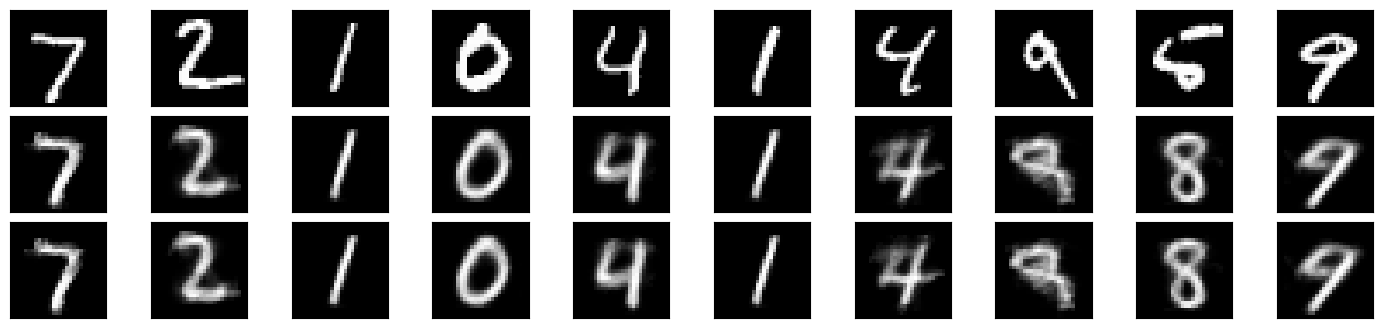

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plot_results(models, data, batch_size=128, model_name="vae"):
    encoder, decoder = models
    x_test = data

    # Encode and decode the test data
    z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)
    x_decoded = decoder.predict(z_mean, batch_size=batch_size)

    # Plot the results
    plt.figure(figsize=(18, 4))
    for i in range(10):
        # Original images
        ax = plt.subplot(3, 10, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Reconstructed images from step 2
        ax = plt.subplot(3, 10, i + 1 + 10)
        plt.imshow(x_decoded_step2[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Reconstructed images from step 3
        ax = plt.subplot(3, 10, i + 1 + 20)
        plt.imshow(x_decoded_step3[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

# Generate reconstructions
x_decoded_step2 = vae.predict(x_test, batch_size=batch_size)

# Fine-tune the model and generate new reconstructions
vae.compile(optimizer='adam')
vae.fit(x_train_small, epochs=epochs, batch_size=batch_size, validation_data=(x_test_small, None))
x_decoded_step3 = vae.predict(x_test, batch_size=batch_size)

# Plot the results
plot_results((encoder, decoder), x_test)


Evaluating the Losses
The reduction in loss from 136 to 122 during fine-tuning indicates that the model has improved in terms of reconstruction quality on the smaller dataset. This suggests that the transfer learning process has effectively adapted the pre-trained VAE to the new, smaller dataset, capturing its specific features better.

Code to Compare Samples
To visually compare the samples is provided in step 4, we'll plot the original images, the reconstructed images from the model trained in step 2, and the reconstructed images from the fine-tuned model in step 3.
Detailed Explanation
Data Encoding and Decoding:

We encode and decode the test data using the encoder and decoder to get the reconstructed images from both the initial and fine-tuned models.
Plotting the Results:

We plot three rows of images:
The first row shows the original images.
The second row shows the reconstructed images from the model trained in step 2.
The third row shows the reconstructed images from the fine-tuned model in step 3.
Visualization:

This visual comparison helps us see the improvements in the reconstruction quality after fine-tuning. Ideally, the images in the third row should look more similar to the original images compared to those in the second row.
Running the Code
To run this code, ensure you have executed the initial VAE training and fine-tuning steps correctly. This script assumes you have already completed those steps and have the necessary models (encoder, decoder, vae) and data (x_test, x_train_small, x_test_small) in memory.

If executed correctly, you should see a plot comparing the original images, the reconstructed images after initial training, and the reconstructed images after fine-tuning, allowing you to visually assess the improvements.






